The strategy for the initial design is to choose several solvents using a latin hypercub in PCA space and then do a latin hypercube for each solvent. 

In [2]:
#Import all the necessary packages
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, ContinuousVariable, DiscreteVariable, DescriptorsVariable
from summit.initial_design.latin_designer import LatinDesigner, lhs
from summit.initial_design.base import _closest_point_indices
from sklearn.decomposition import PCA
import numpy as np
import plotly.graph_objects as go

Create the principal components dataset.

In [3]:
NUM_COMPONENTS = 3

In [4]:
def create_pca_ds(solvent_ds, num_components):
    #Reduce solvent descriptors to 3 principal components
    pca = PCA(n_components=num_components)
    solvent_arr_std = solvent_ds.standardize()
    solvent_arr_pca = pca.fit_transform(solvent_arr_std)

    #Dataset manipulations
    solvent_ds_pcs = DataSet({(f'PC_{i}', 'DATA'): solvent_arr_pca[:, i] for i in range(num_components)}, 
                             index=solvent_ds.index)
    solvent_ds_pcs.columns.names = ['NAME', 'TYPE']
    order = solvent_ds.columns.codes[0]
    num_columns = len(solvent_ds.columns.levels[0])
    solvent_ds_new = solvent_ds.copy()
    solvent_ds_new.columns = solvent_ds.columns.set_codes(np.array([order.tolist(), [1]*num_columns]))
    solvent_ds_pcs = solvent_ds_pcs.join(solvent_ds_new)
    
    return solvent_ds_pcs

solvent_ds_pcs = create_pca_ds(solvent_ds, num_components=NUM_COMPONENTS)
solvent_ds_pcs = solvent_ds_pcs.reindex(ucb_ds.index).dropna()

Now, we need to specify the optimization space.

In [5]:


domain = Domain()

domain += DiscreteVariable(name="co_cat",
                           description="enumeration of the two potential cocatalysts",
                           levels = ['co_cat_1', 'co_cat_2'])


domain += ContinuousVariable(name="catalyst_conc",
                             description = "Concentration of the catalyst in mM",
                             units="mM",
                             bounds=[0.1, 3])

domain += ContinuousVariable(name="cocatalyst_conc",
                             description = "co-catalyst loading",
                             bounds=[15, 1000])


domain += ContinuousVariable(name="substrate_a_conc",
                             description = "We should specifiy this, in millimolar",
                             units="mM",
                             bounds = [10, 1000])

domain += ContinuousVariable(name="substrate_b_a_ratio",
                             description = "Ratio of substrate b to a",
                             units="mM",
                             bounds = [0.5, 2])

domain += ContinuousVariable(name='temperature',
                             description = "reaction temperature",
                             bounds=[20, 50])


domain += DescriptorsVariable(name="solvent",
                             description="Descriptors of the solvent",
                             ds=solvent_ds_pcs)

domain #The domain should display as an html table 

Name,Type,Description,Values
co_cat,"discrete, input",enumeration of the two potential cocatalysts,2 levels
catalyst_conc,"continuous, input",Concentration of the catalyst in mM,"[0.1,3]"
cocatalyst_conc,"continuous, input",co-catalyst loading,"[15,1000]"
substrate_a_conc,"continuous, input","We should specifiy this, in millimolar","[10,1000]"
substrate_b_a_ratio,"continuous, input",Ratio of substrate b to a,"[0.5,2]"
temperature,"continuous, input",reaction temperature,"[20,50]"
solvent,"descriptors, input",Descriptors of the solvent,80 examples of 3 descriptors


Set up the initial design. Start with solvent/.

In [10]:
random_seed = 500
rs = np.random.RandomState(random_seed)
continuous_design = lhs(NUM_COMPONENTS, 8, random_state=rs)
solvent_arr_pcs = solvent_ds_pcs.zero_to_one()
design_indices = _closest_point_indices(continuous_design, solvent_arr_pcs)
design_arr_pcs = solvent_arr_pcs[design_indices[:, 0]] 

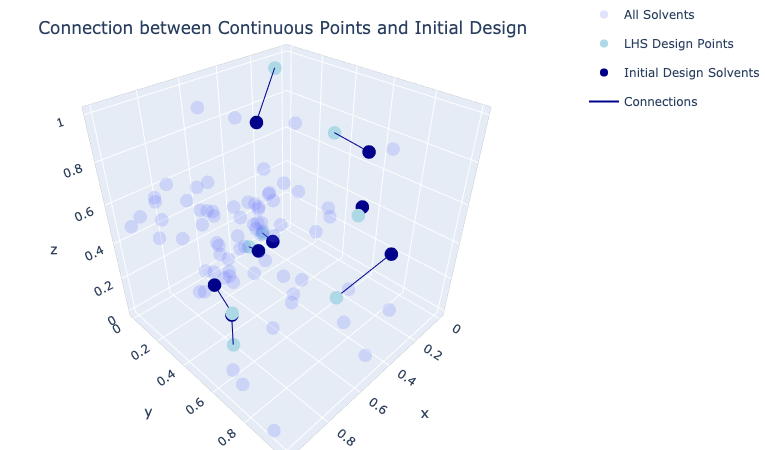

In [11]:
all_solvents_plot = go.Scatter3d(x=solvent_arr_pcs[:, 0],
                                 y=solvent_arr_pcs[:, 1],
                                 z=solvent_arr_pcs[:, 2],
                                 mode='markers',
                                 marker=dict(opacity=0.2),
                                 name='All Solvents')

lines = [go.Scatter3d(x=[solvents[0], continuous[0]],
                      y=[solvents[1], continuous[1]],
                      z=[solvents[2], continuous[2]], 
                      legendgroup='connections',
                      name='Connections',
                      showlegend= True if i==0 else False,
                      mode='lines',
                      line=dict(
                                color='darkblue',
                                width=2)
                      
                     )
         for i, (solvents, continuous) in enumerate(zip(design_arr_pcs, continuous_design))]

continuous_design_plot = go.Scatter3d(x=continuous_design[:, 0],
                                      y=continuous_design[:, 1],
                                      z=continuous_design[:, 2],
                                      mode='markers',
                                      marker=dict(opacity=1.0, color='lightblue'),
                                      name='LHS Design Points')

design_solvents_plot = go.Scatter3d(x=design_arr_pcs[:, 0],
                                    y=design_arr_pcs[:, 1],
                                    z=design_arr_pcs[:, 2], 
                                    mode='markers',
                                    marker=dict(color='darkblue'),
                                    name='Initial Design Solvents')

fig = go.Figure([all_solvents_plot, continuous_design_plot, design_solvents_plot] + lines)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), 
                  title=dict(text='Connection between Continuous Points and Initial Design',
                             y=0.95),
                  xaxis=dict(title="Hello"))
fig.show()

In [12]:
listed = solvent_ds_pcs.iloc[design_indices[:, 0]][['stenutz_name', 'PC_0', 'PC_1', 'PC_2']]
listed.to_csv('outputs/solvents.csv')
listed

,stenutz_name,PC_0,PC_1,PC_2
cas_number,,,,
108-75-8,"2,4,6-trimethylpyridine",1.184633,0.835695,-0.572573
111-96-6,bis(2-methoxyethyl) ether,0.180195,0.386132,-2.146215
75-09-2,dichloromethane,-2.763849,-1.023328,2.128500
78-93-3,2-butanone,-2.516735,-0.907149,-1.537832
64-18-6,formic acid,-5.871235,1.786280,1.317638
56-81-5,"1,2,3-propanetriol",-3.483674,4.709093,0.082542
107-21-1,ethanediol,-4.529107,2.642788,0.375805
67-64-1,2-propanone,-3.510160,-1.058576,-1.611283


In [16]:
rs = np.random.RandomState(100)
lhs = LatinDesigner(domain, random_state=rs)
design = lhs.generate_experiments(num_experiments=16, criterion='center', 
                                  unique=False,exclude=['solvent'])
design = design.to_frame().sort_values(by=['co_cat']).round(2)
design.to_csv('outputs/continuous.csv')
design

,co_cat,catalyst_conc,cocatalyst_conc,substrate_a_conc,substrate_b_a_ratio,temperature
2,co_cat_1,1.64,722.97,535.94,1.30,35.94
4,co_cat_1,0.19,168.91,597.81,1.86,20.94
6,co_cat_1,0.37,599.84,845.31,1.48,37.81
7,co_cat_1,1.46,784.53,721.56,1.77,49.06
8,co_cat_1,2.55,476.72,659.69,1.67,45.31
14,co_cat_1,2.37,107.34,40.94,1.02,26.56
0,co_cat_2,2.73,538.28,288.44,1.20,22.81
1,co_cat_2,1.82,969.22,474.06,0.55,39.69
3,co_cat_2,0.55,846.09,412.19,1.58,32.19
5,co_cat_2,0.73,292.03,783.44,1.39,30.31
